In [13]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import os
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import pickle
import time
import pandas as pd

In [38]:
class RewardGraphic():
    def __init__(self, window_size=1000):
        self.window_size = window_size

    def Graphic_reward_per_episode(self, rewards_per_episode, episodes, epsilons):
        plt.figure(figsize=(10, 6))  # Tamaño de la figura
        
        for i, epsilon in enumerate(epsilons):
            sum_rewards = np.zeros(episodes)
            for t in range(episodes):
                sum_rewards[t] = np.sum(rewards_per_episode[epsilon][max(0, t-self.window_size):(t+1)])

            print(f"Final average reward for alpha={epsilon}:", np.mean(sum_rewards[-1000:]))
            plt.plot(sum_rewards, label=f'$alpha$ = {epsilon}')

        plt.xlabel('Episodes')
        plt.ylabel('Suma de recompensas')
        plt.title('Suma de recompensas a lo largo del tiempo')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'CliffWalking_combined.png')
        plt.show()
        
    def Graphic_reward_per_epsilon(self, reward_per_epsilon, epsilons):
        plt.figure(figsize=(8, 5))
        for epsilon in epsilons:
            plt.plot(reward_per_epsilon[epsilon], label=f'alpha = {epsilon}')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Episodios')
        plt.ylabel('Recompensa media')
        plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')
        plt.show()

<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_8728\2640702854.py:32: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')


In [15]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [16]:
class Game():
    def __init__(self, Agent, explore=True):
        self.agent = Agent
        self.explore = explore
        self.is_explore()
        
    def is_explore(self):
        if self.explore:
            self.agent.H = np.zeros((self.agent.env.observation_space.n, self.agent.env.action_space.n))
            self.agent.pi = np.array([softmax(self.agent.H[s]) for s in range(self.agent.env.observation_space.n)])
        else:
            self.agent.load_pickle()
        
    def run(self, episodes=100):
        RENDER_AT_EPISODE = 10
        rewards_per_episode = np.zeros(episodes)
        steps_per_episode = np.zeros(episodes)
        
        for episode in range(episodes):
            state = self.agent.reset()
            episode_reward = 0
            episode_steps = 0
            rewards = []
            terminated = False
            truncated = False
            
            while not terminated and not truncated:
                
                action = self.agent.choose_action(state, self.explore)
                # print(f"S: {state}, {action}")s
                next_state, reward, terminated, truncated, _ = self.agent.env.step(action)
                
                if self.explore:
                    rewards.append(reward)
                    baseline = np.mean(rewards)
                    self.agent.update(state, action, reward, baseline)
                
                state = next_state
                episode_reward += reward
                episode_steps += 1
                
            if episode % RENDER_AT_EPISODE == 0 and self.agent.env.render_mode == "human":
                self.agent.env.render()

            # self.agent.epsilon = max(self.agent.epsilon - self.agent.epsilon_decay_rate, 0.01)
            print(f"Episode {episode}/{episodes}, Alpha: {self.agent.alpha:.4f}, Reward: {episode_reward:.4f}")
            rewards_per_episode[episode] = episode_reward
            steps_per_episode[episode] = episode_steps
        self.agent.save_pickle()
        self.close()
        return rewards_per_episode, steps_per_episode
    
    def close(self):
        print("Closing environment")
        if self.agent.env:
            self.agent.env.close()

In [17]:
class Agent():
    def __init__(self,env, alpha=0.01, gamma=0.99):
        #hiperparametros
        self.alpha = alpha
        #variables
        self.url_pickle = f"CliffWalking_alpha_{self.alpha}.pkl"
        self.episode_reward = 0
        self.env = env
        self.action_counts = np.zeros((env.observation_space.n, env.action_space.n))
        #variables para la matriz de politicas
        self.H = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.pi = softmax(self.H)
    
    def reset(self):
        return self.env.reset()[0]
    
    def choose_action(self, state, explore):
        if explore:
            return np.random.choice(self.env.action_space.n, p=self.pi[state])
        else:
            return np.argmax(self.pi[state])

    def update(self, state, action, reward, baseline):
        for a in range(self.env.action_space.n):
            if a == action:
                self.H[state][a] += self.alpha * (reward - baseline) * (1 - self.pi[state][a])
            else:
                self.H[state][a] -= self.alpha * (reward - baseline) * self.pi[state][a]
        self.pi[state] = softmax(self.H[state])
    
    def save_pickle(self):
        with open(self.url_pickle, "wb") as f:
            pickle.dump({'H': self.H, 'pi': self.pi}, f)

    def load_pickle(self):
        print("Loading pickle")
        try:
            with open(self.url_pickle, 'rb') as f:
                data = pickle.load(f)
                self.H = data['H']
                self.pi = data['pi']
        except FileNotFoundError:
            print(f"Pickle file {self.url_pickle} not found. Using default values.")

In [18]:
alphas = [0.01, 0.009, 0.0001]
reward_per_alpha = {}
reward_per_episode = {}
games = {}
render = False
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)

# Crear juegos y agentes
for alpha in alphas:
    agent = Agent(env, alpha)
    game = Game(agent, explore=True)
    games[alpha] = game

# Ejecutar episodios
for alpha, game in games.items():
    episodes = 2000
    rewards_per_episode, _ = game.run(episodes)
    reward_per_episode[alpha] = rewards_per_episode
    reward_per_alpha[alpha] = rewards_per_episode / episodes

Episode 0/2000, Alpha: 0.0100, Reward: -1394.0000
Episode 1/2000, Alpha: 0.0100, Reward: -3263.0000
Episode 2/2000, Alpha: 0.0100, Reward: -161.0000
Episode 3/2000, Alpha: 0.0100, Reward: -1758.0000
Episode 4/2000, Alpha: 0.0100, Reward: -359.0000
Episode 5/2000, Alpha: 0.0100, Reward: -94.0000
Episode 6/2000, Alpha: 0.0100, Reward: -355.0000
Episode 7/2000, Alpha: 0.0100, Reward: -79.0000
Episode 8/2000, Alpha: 0.0100, Reward: -160.0000
Episode 9/2000, Alpha: 0.0100, Reward: -1331.0000
Episode 10/2000, Alpha: 0.0100, Reward: -1572.0000
Episode 11/2000, Alpha: 0.0100, Reward: -131.0000
Episode 12/2000, Alpha: 0.0100, Reward: -342.0000
Episode 13/2000, Alpha: 0.0100, Reward: -938.0000
Episode 14/2000, Alpha: 0.0100, Reward: -350.0000
Episode 15/2000, Alpha: 0.0100, Reward: -441.0000
Episode 16/2000, Alpha: 0.0100, Reward: -639.0000
Episode 17/2000, Alpha: 0.0100, Reward: -187.0000
Episode 18/2000, Alpha: 0.0100, Reward: -426.0000
Episode 19/2000, Alpha: 0.0100, Reward: -690.0000
Episode

Final average reward for alpha=0.01: -5183328.168
Final average reward for alpha=0.009: -497619.685
Final average reward for alpha=0.0001: -653579.188


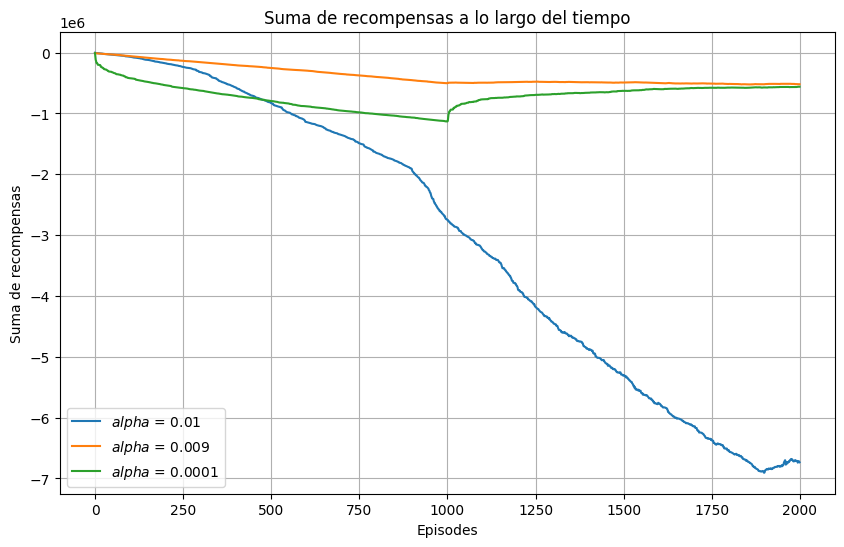

: 

In [39]:
graphic = RewardGraphic()
graphic.Graphic_reward_per_episode(reward_per_episode, episodes, alphas)

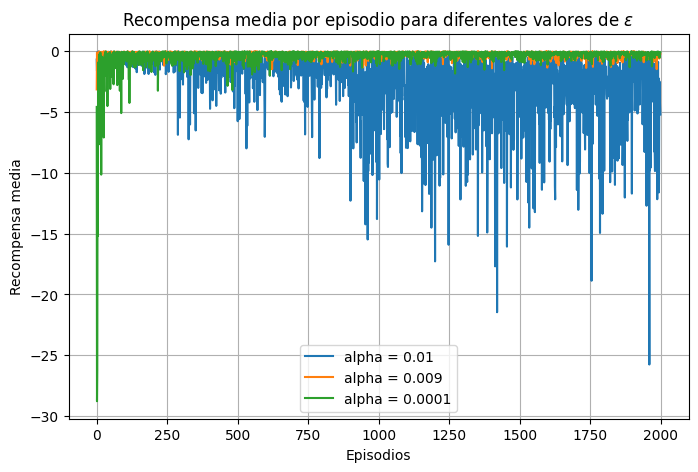

In [31]:
graphic.Graphic_reward_per_epsilon(reward_per_alpha, alphas)

In [37]:
render = True
explore = False
alpha = 0.01
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)
agent = Agent(env, alpha)
game = Game(agent, explore= False)
game.run(2)

Loading pickle


KeyboardInterrupt: 

0: Move up

1: Move right

2: Move down

3: Move left

In [36]:
q_df = pd.DataFrame(games[0.01].agent.pi)
print("Q-table as DataFrame:")
q_df

Q-table as DataFrame:


,0,1,2,3
0,0.239972,2.829275e-01,0.226527,0.250574
1,0.221020,2.975002e-01,0.231618,0.249862
2,0.267177,1.957608e-01,0.299085,0.237977
3,0.258595,2.561812e-01,0.249471,0.235752
4,0.277706,2.288092e-01,0.255037,0.238447
5,0.268965,2.525112e-01,0.235960,0.242564
6,0.246483,2.597920e-01,0.242027,0.251698
7,0.249307,2.519197e-01,0.245264,0.253509
8,0.248845,2.466172e-01,0.252464,0.252074
9,0.258821,2.467817e-01,0.246682,0.247715
